In [29]:
import numpy as np 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore",  category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning,)
warnings.filterwarnings("ignore", category=UserWarning)

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [30]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

### Zmiana typu kolumn numerycznych na INT64

In [31]:
cols_to_convert = ['Time_spent_Alone', 'Social_event_attendance','Going_outside',  'Friends_circle_size','Post_frequency']
train_df[cols_to_convert] = train_df[cols_to_convert].astype('Int64')

In [32]:
train_df['Drained_after_socializing' + '_MISS'] = train_df['Drained_after_socializing'].notna().astype(int)

In [33]:
# Uzupełnienie danych Yes - Yes // No- No
train_df['Stage_fear'] = train_df['Stage_fear'].mask(train_df['Stage_fear'].isna() & train_df['Drained_after_socializing']
                                            .notna(), train_df['Drained_after_socializing'])
train_df['Drained_after_socializing'] = train_df['Drained_after_socializing'].mask(train_df['Drained_after_socializing']
                                            .isna() & train_df['Stage_fear'].notna(), train_df['Stage_fear'])

In [34]:
cat_cols = ['Stage_fear','Drained_after_socializing']  # <-- tu wpisz swoje kolumny kategoryczne
train_df[cat_cols]=train_df[cat_cols].fillna('Missing').astype(str)

In [35]:
train_df['Personality']=train_df['Personality'].map({'Introvert':0,'Extrovert':1})

### Alternatywne Markery do wartości granicznych

def three(x):
    if x==3:
        return 1
    else:
        return 0

def four(x):
    if x==4:
        return 1
    else:
        return 0

def five(x):
    if x==5:
        return 1
    else:
        return 0

train_df['Time_spent_Alone_MARK'] = train_df['Time_spent_Alone'].apply(four)
train_df['Social_event_attendance_MARK'] = train_df['Social_event_attendance'].apply(three)
train_df['Going_outside_MARK'] = train_df['Going_outside'].apply(three)
train_df['Friends_circle_size_MARK'] = train_df['Friends_circle_size'].apply(five)
train_df['Post_frequency_MARK'] = train_df['Post_frequency'].apply(three)

cat_features = ['Drained_after_socializing', 'Outside_mult_Friends', 'Time_Alone_dev_Outside','Drained_after_socializing_MISS','Stage_fear',
               'Time_spent_Alone_MARK', 'Social_event_attendance_MARK', 'Going_outside_MARK', 'Friends_circle_size_MARK', 'Post_frequency_MARK']

## dwie dobre kolumny do właczenia

In [36]:
train_df['Outside_mult_Friends'] = train_df['Going_outside'] * train_df['Friends_circle_size']
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= 11:
            return 0
        elif x > 11 and x <= 15:
            return 1
        elif x > 15 and x < 400:
            return 2
        else:
            return 2
    except ValueError:
        return 2

train_df['Outside_mult_Friends']=train_df['Outside_mult_Friends'].apply(Outside_mult_Friends).astype('Int64')

In [37]:
train_df['Time_Alone_dev_Outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].round(2).astype(float)
def Time_Alone_dev_Outside (x):
    try:
        x=float(x)
        if x <= 1:
            return 0
        elif x > 1 and x < 2:
            return 1
        elif x >= 2 and x < 100:
            return 2
        else:
            return 3
    except ValueError:
        return 3

train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].apply(Time_Alone_dev_Outside).astype('Int64')

## Dodajemy kolumny z odejmowaniem

train_df['Fri_sub_Post']=train_df['Friends_circle_size'] - train_df['Post_frequency']

train_df['Goi_sub_Post']=train_df['Going_outside'] - train_df['Post_frequency']

train_df['Goi_sub_Fri']=train_df['Going_outside'] - train_df['Friends_circle_size']

train_df['Soc_sub_Post']=train_df['Social_event_attendance'] - train_df['Post_frequency']

train_df['Soc_sub_Fri']=train_df['Social_event_attendance'] - train_df['Friends_circle_size']

train_df['Soc_sub_Goi']=train_df['Social_event_attendance'] - train_df['Going_outside']

train_df['Tim_sub_Post']=train_df['Time_spent_Alone'] - train_df['Post_frequency']

train_df['Tim_sub_Fri']=train_df['Time_spent_Alone'] - train_df['Friends_circle_size']

train_df['Tim_sub_Goi']=train_df['Time_spent_Alone'] - train_df['Going_outside']

train_df['Tim_sub_Soc']=train_df['Time_spent_Alone'] - train_df['Social_event_attendance']

## Dodatkowe kolumny z dodawaniemm

train_df['Fri_Sum_Post']=train_df['Friends_circle_size'] + train_df['Post_frequency']

train_df['Goi_Sum_Fri']=train_df['Going_outside'] + train_df['Friends_circle_size']

train_df['Goi_Sum_Post']=train_df['Going_outside'] + train_df['Post_frequency']

train_df['Soc_Sum_Post']=train_df['Social_event_attendance'] + train_df['Post_frequency']

train_df['Soc_Sum_Goi']=train_df['Social_event_attendance'] + train_df['Going_outside']

## CATBOOST

In [38]:
X=train_df.drop([ 'id','Personality','Stage_fear'], axis=1).copy()
y=train_df['Personality'].copy()

In [39]:
cat_features = ['Drained_after_socializing',  'Outside_mult_Friends', 'Time_Alone_dev_Outside','Drained_after_socializing_MISS']

#'Drained_after_socializing', 'Outside_mult_Friends', 'Time_Alone_dev_Outside', 
# 1. Inicjalizacja modelu (bez uczenia, bez pipeline'u)Time_Alone_dev_Outside
model = CatBoostClassifier(random_seed=42,verbose=100, cat_features=cat_features)  # verbose=0 żeby nie spamował

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Zbiór parametrów do przeszukania
param_grid = {
    'learning_rate': [  0.04],#, 0.05, 0.1],
    'depth': [ 6],#, 8],
    #'l2_leaf_reg': [4,5,3,6],#, 3],
    'iterations': [  250], #opt 200
    #'auto_class_weights': ['SqrtBalanced'] #'Balanced', 'None', 
}

# 3. GridSearchCV (tu możesz dodać scoring, cv, n_jobs itd.)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',       # lub 'roc_auc', 'f1', zależnie od problemu
    cv=cv,                      # 5-fold cross-validation
    n_jobs=-1,                 # pełne równoległe obciążenie CPU
    return_train_score=True
)

# 4. Dopasowanie do danych (X to features, y to target)
grid_search.fit(X, y)

# 5. Wyniki
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

best_model_CatBoost = grid_search.best_estimator_

# Ponowne fitowanie z cat_features
#best_model.set_params(cat_features=cat_features)
#best_model.fit(train_df.drop(['id','Personality'], axis=1), train_df['Personality'])
eval_pool = Pool(X, y, cat_features=cat_features)
importances = best_model_CatBoost.get_feature_importance(eval_pool)

y_proba_cat = best_model_CatBoost.predict_proba(X)[:, 1]

res_df = pd.DataFrame(grid_search.cv_results_)
res_df[['rank_test_score','mean_test_score','mean_train_score','std_test_score','params']]

0:	learn: 0.6293924	total: 68.9ms	remaining: 17.1s
100:	learn: 0.1248784	total: 1.46s	remaining: 2.15s
200:	learn: 0.1214170	total: 2.87s	remaining: 699ms
249:	learn: 0.1200600	total: 3.54s	remaining: 0us
Najlepsze parametry: {'depth': 6, 'iterations': 250, 'learning_rate': 0.04}
Najlepszy wynik: 0.969893113835637


,rank_test_score,mean_test_score,mean_train_score,std_test_score,params
0,1,0.969893,0.977584,0.002933,"{'depth': 6, 'iterations': 250, 'learning_rate..."


<Figure size 1000x600 with 0 Axes>

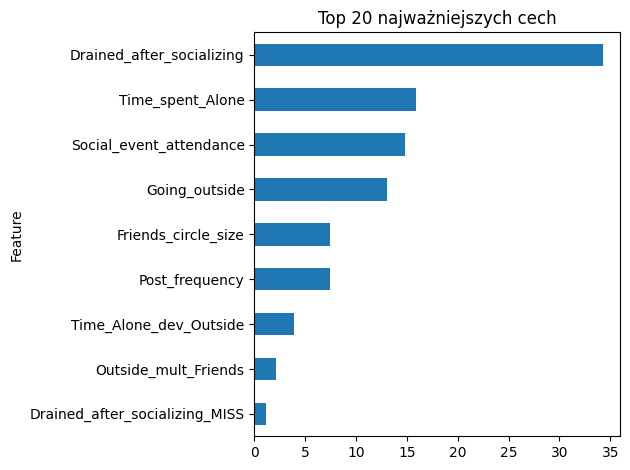

In [40]:

# Wyciągnięcie ważności cech
#importances = best_model.get_feature_importance(Pool(train_df.drop(['id','Personality'], axis=1), train_df['Personality']))
feature_names = X.columns

# DataFrame z ważnościami
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Wyświetlenie najważniejszych cech
plt.figure(figsize=(10, 6))
fi_df.head(30).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 20 najważniejszych cech")
plt.tight_layout()
plt.show()

# __________________________________ NOWY MODEL XGBOOST_______________________________________

In [41]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

cols_to_convert = ['Time_spent_Alone', 'Social_event_attendance','Going_outside',  'Friends_circle_size','Post_frequency']
train_df[cols_to_convert] = train_df[cols_to_convert].astype('Int64')

train_df['Drained_after_socializing' + '_MISS'] = train_df['Drained_after_socializing'].notna().astype(int)

# Uzupełnienie danych Yes - Yes // No- No
train_df['Stage_fear'] = train_df['Stage_fear'].mask(train_df['Stage_fear'].isna() & train_df['Drained_after_socializing']
                                            .notna(), train_df['Drained_after_socializing'])
train_df['Drained_after_socializing'] = train_df['Drained_after_socializing'].mask(train_df['Drained_after_socializing']
                                            .isna() & train_df['Stage_fear'].notna(), train_df['Stage_fear'])

cat_cols = ['Stage_fear','Drained_after_socializing']  # <-- tu wpisz swoje kolumny kategoryczne
train_df['Drained_after_socializing']=train_df['Drained_after_socializing'].map({'Yes':2,'No':1})
train_df['Drained_after_socializing']=train_df['Drained_after_socializing'].fillna(0).astype('int')
train_df = train_df.drop('Stage_fear', axis=1)
# Kodowanie labelek
train_df['Personality']=train_df['Personality'].map({'Introvert':0,'Extrovert':1})

In [42]:
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']   
num_imputer = IterativeImputer(estimator=LGBMRegressor(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, verbosity=-1),
                               max_iter=10, random_state=42)
train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])
columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']
train_df[columns]=train_df[columns].round().astype(int)

In [43]:
X = train_df.drop('Personality', axis=1).copy()
y = train_df['Personality'].copy()

In [44]:
model = XGBClassifier()  # verbose=0 żeby nie spamował

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Zbiór parametrów do przeszukania
param_grid = {
    'n_estimators': [200],#[100, 200, 300],
    'learning_rate': [0.02],#[0.01, 0.05, 0.1],
    'max_depth': [  3 ],#[3, 5, 7, 10],
    'subsample': [1.0],#, 1.0],
    'colsample_bytree': [ 0.6],#, 0.9, 1.0],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [0.5]
}

# 3. GridSearchCV (tu możesz dodać scoring, cv, n_jobs itd.)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',       # lub 'roc_auc', 'f1', zależnie od problemu
    cv=cv,                      # 5-fold cross-validation
    n_jobs=-1,                 # pełne równoległe obciążenie CPU
    return_train_score=True
)

# 4. Dopasowanie do danych (X to features, y to target)
grid_search.fit(X, y)

# 5. Wyniki
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

best_model_XGBC = grid_search.best_estimator_
y_proba_xgb = best_model_XGBC.predict_proba(X)[:, 1]
# Ponowne fitowanie z cat_features
#best_model.set_params(cat_features=cat_features)
#best_model.fit(train_df.drop(['id','Personality'], axis=1), train_df['Personality'])
#eval_pool = Pool(X, y)
#importances = best_model.get_feature_importance(eval_pool)

res_df = pd.DataFrame(grid_search.cv_results_)
res_df[['rank_test_score','mean_test_score','mean_train_score','std_test_score','params']]

Najlepsze parametry: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 1.0}
Najlepszy wynik: 0.9705427026430223


,rank_test_score,mean_test_score,mean_train_score,std_test_score,params
0,2,0.970121,0.976935,0.004508,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin..."
1,1,0.970543,0.974006,0.004333,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin..."


# __________________________________ LIGHT XBGOOST ____________

In [46]:
model = LGBMClassifier(verbose=-1)  # verbose=0 żeby nie spamował

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Zbiór parametrów do przeszukania
param_grid = {
    'n_estimators': [375],
    'learning_rate': [0.01],
    'max_depth': [ 3],  # -1 to bez limitu
    'num_leaves': [15],  # powiązane z max_depth
    'min_child_samples': [ 9 ],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'reg_alpha': [0],
    'reg_lambda': [0.5]
}

# 3. GridSearchCV (tu możesz dodać scoring, cv, n_jobs itd.)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',       # lub 'roc_auc', 'f1', zależnie od problemu
    cv=cv,                      # 5-fold cross-validation
    n_jobs=-1,                 # pełne równoległe obciążenie CPU
    return_train_score=True
)

# 4. Dopasowanie do danych (X to features, y to target)
grid_search.fit(X, y)

# 5. Wyniki
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

best_model_LightGBMC = grid_search.best_estimator_

# Ponowne fitowanie z cat_features
#best_model.set_params(cat_features=cat_features)
#best_model.fit(train_df.drop(['id','Personality'], axis=1), train_df['Personality'])
#eval_pool = Pool(X, y)
#importances = best_model.get_feature_importance(eval_pool)

y_proba_lgb = best_model_LightGBMC.predict_proba(X)[:, 1]

res_df = pd.DataFrame(grid_search.cv_results_)
res_df[['rank_test_score','mean_test_score','mean_train_score','std_test_score','params']]

Najlepsze parametry: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 9, 'n_estimators': 375, 'num_leaves': 15, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.8}
Najlepszy wynik: 0.970465878062656


,rank_test_score,mean_test_score,mean_train_score,std_test_score,params
0,1,0.970466,0.973677,0.003994,"{'colsample_bytree': 0.7, 'learning_rate': 0.0..."


# __________________________________ KNN & Logistic regression ______________________________

In [47]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

cols_to_convert = ['Time_spent_Alone', 'Social_event_attendance','Going_outside',  'Friends_circle_size','Post_frequency']
train_df[cols_to_convert] = train_df[cols_to_convert].astype('Int64')

train_df['Drained_after_socializing' + '_MISS'] = train_df['Drained_after_socializing'].notna().astype(int)

# Uzupełnienie danych Yes - Yes // No- No
train_df['Stage_fear'] = train_df['Stage_fear'].mask(train_df['Stage_fear'].isna() & train_df['Drained_after_socializing']
                                            .notna(), train_df['Drained_after_socializing'])
train_df['Drained_after_socializing'] = train_df['Drained_after_socializing'].mask(train_df['Drained_after_socializing']
                                            .isna() & train_df['Stage_fear'].notna(), train_df['Stage_fear'])

cat_cols = ['Stage_fear','Drained_after_socializing']  # <-- tu wpisz swoje kolumny kategoryczne
train_df['Drained_after_socializing']=train_df['Drained_after_socializing'].map({'Yes':2,'No':1})
train_df['Drained_after_socializing']=train_df['Drained_after_socializing'].fillna(0).astype('int')
train_df = train_df.drop('Stage_fear', axis=1)
# Kodowanie labelek
train_df['Personality']=train_df['Personality'].map({'Introvert':0,'Extrovert':1})

In [48]:
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']   
num_imputer = IterativeImputer(estimator=LGBMRegressor(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, verbosity=-1),
                               max_iter=10, random_state=42)
train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])
columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']
train_df[columns]=train_df[columns].round().astype(int)

In [49]:

scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X_encoded)

In [50]:
X = train_df.drop(['id','Personality'], axis=1).copy()
y = train_df['Personality'].copy()
X = scaler.fit_transform(X)

In [51]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Parametry do testu
param_grid_lr = {
    'C': [1, ],
    'penalty': ['l2'],  # l1 dostępne tylko przy solver='liblinear'
    'solver': ['lbfgs'],  # stabilny solver dla multiclass
    'max_iter': [ 3000]
}

grid_lr = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid_lr,
    cv=cv,
    scoring='accuracy',  # lub 'roc_auc' dla binary
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X, y)

# Najlepszy model
best_lr = grid_lr.best_estimator_

# Prawdopodobieństwa (dla danych treningowych X)
y_proba_lr = best_lr.predict_proba(X)[:, 1]


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [52]:
res_df = pd.DataFrame(grid_lr.cv_results_)
res_df[['rank_test_score','mean_test_score','std_test_score','params']]

,rank_test_score,mean_test_score,std_test_score,params
0,1,0.96761,0.002177,"{'C': 1, 'max_iter': 3000, 'penalty': 'l2', 's..."


In [53]:


# Parametry do testu
param_grid_knn = {
    'n_neighbors': [ 11],
    'weights': ['uniform'],
    'metric': ['euclidean']
}

grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X, y)

# Najlepszy model
best_knn = grid_knn.best_estimator_

# Prawdopodobieństwa

res_df = pd.DataFrame(grid_knn.cv_results_)
res_df[['rank_test_score','mean_test_score','std_test_score','params']]
print("Najlepsze parametry:", grid_knn.best_params_)
print("Najlepszy wynik:", grid_knn.best_score_)
y_proba_knn = best_knn.predict_proba(X)[:, 1]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Najlepsze parametry: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Najlepszy wynik: 0.9688513566687945


# __________________________________________ ENESEMBLE________________________________

In [54]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Stacking: tworzymy nową macierz X dla metamodelu
X_stack = np.column_stack([
    y_proba_lr,
    y_proba_knn,
    y_proba_cat,
    y_proba_xgb,
    y_proba_lgb
])

# Możesz też nazwać kolumny, jeśli chcesz później analizować feature importance

# Meta-model: Logistic Regression
meta_model = LogisticRegression()
meta_model.fit(X_stack, y)

# Predykcja końcowa (prawdopodobieństwo klasy 1)
y_proba_meta = meta_model.predict_proba(X_stack)[:, 1]

# Jeśli chcesz ocenić skuteczność:
from sklearn.metrics import roc_auc_score
print("Meta-model ROC AUC:", roc_auc_score(y, y_proba_meta))

Meta-model ROC AUC: 0.99216495133906


In [57]:
# Zamień progiem 0.5
y_pred_labels = (y_proba_meta >= 0.5).astype(int)

# Jeśli Twoje klasy są np. ['Extrovert', 'Introvert'], to:
label_map = {0: meta_model.classes_[0], 1: meta_model.classes_[1]}
y_pred_final = [label_map[i] for i in y_pred_labels]

In [61]:
submission = pd.DataFrame({
    "Id": train_df["id"],        # lub np. range(len(y_pred_final))
    "Personality": y_pred_final
})

submission['Personality']=submission['Personality'].map({0:'Introvert',1:'Extrovert'})
submission.head()

,Id,Personality
0,0,Extrovert
1,1,Extrovert
2,2,Introvert
3,3,Extrovert
4,4,Extrovert


# __________________________________ NOWY MODEL CATBOOST TYLKO KATEGORIE _______________________________

In [ ]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

cols_to_convert = ['Time_spent_Alone', 'Social_event_attendance','Going_outside',  'Friends_circle_size','Post_frequency']
train_df[cols_to_convert] = train_df[cols_to_convert].astype('Int64')

train_df['Drained_after_socializing' + '_MISS'] = train_df['Drained_after_socializing'].notna().astype(int)

# Uzupełnienie danych Yes - Yes // No- No
train_df['Stage_fear'] = train_df['Stage_fear'].mask(train_df['Stage_fear'].isna() & train_df['Drained_after_socializing']
                                            .notna(), train_df['Drained_after_socializing'])
train_df['Drained_after_socializing'] = train_df['Drained_after_socializing'].mask(train_df['Drained_after_socializing']
                                            .isna() & train_df['Stage_fear'].notna(), train_df['Stage_fear'])

cat_cols = ['Stage_fear','Drained_after_socializing']  # <-- tu wpisz swoje kolumny kategoryczne
train_df[cat_cols]=train_df[cat_cols].fillna('Missing').astype(str)
train_df = train_df.drop('Stage_fear', axis=1)

In [ ]:
excluded_cols = ['id', 'Personality', 'Drained_after_socializing_MISS']
all_columns = train_df.columns
# Przetwarzanie pozostałych kolumn
for col in all_columns:
    if col not in excluded_cols:
        train_df[col + '_MISS'] = train_df[col].notna().astype(int)

columns = ['Time_spent_Alone_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS','Drained_after_socializing_MISS', 
           'Friends_circle_size_MISS','Post_frequency_MISS']
train_df['not_MISS_total'] = train_df[columns].sum(axis=1)

# dwie dobre kolumny do właczenia

In [ ]:
train_df['Outside_mult_Friends'] = train_df['Going_outside'] * train_df['Friends_circle_size']
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= 11:
            return 0
        elif x > 11 and x <= 15:
            return 1
        elif x > 15 and x < 400:
            return 2
        else:
            return 2
    except ValueError:
        return 2

train_df['Outside_mult_Friends']=train_df['Outside_mult_Friends'].apply(Outside_mult_Friends).astype('Int64')

In [ ]:
train_df['Time_Alone_dev_Outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].round(2).astype(float)
def Time_Alone_dev_Outside (x):
    try:
        x=float(x)
        if x <= 1:
            return 0
        elif x > 1 and x < 2:
            return 1
        elif x >= 2 and x < 100:
            return 2
        else:
            return 3
    except ValueError:
        return 3

train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].apply(Time_Alone_dev_Outside).astype('Int64')

## Odejmowanie kolumn

In [ ]:
train_df['Fri_sub_Post']=train_df['Friends_circle_size'] - train_df['Post_frequency']

In [ ]:
train_df['Goi_sub_Post']=train_df['Going_outside'] - train_df['Post_frequency']

In [ ]:
train_df['Goi_sub_Fri']=train_df['Going_outside'] - train_df['Friends_circle_size']

In [ ]:
train_df['Soc_sub_Post']=train_df['Social_event_attendance'] - train_df['Post_frequency']

In [ ]:
train_df['Soc_sub_Fri']=train_df['Social_event_attendance'] - train_df['Friends_circle_size']

In [ ]:
train_df['Soc_sub_Goi']=train_df['Social_event_attendance'] - train_df['Going_outside']
def soc_goi (x):
    if x <= -4:
        return 0
    elif x >= -3 and x <= 3:
        return 1
    elif x > 3 and x<= 7:
        return 2
    elif x > 8:
        return 3
    else:
        return 4
train_df['Soc_sub_Goi']=train_df['Soc_sub_Goi'].apply(soc_goi).astype('Int64')

In [ ]:
train_df['Tim_sub_Post']=train_df['Time_spent_Alone'] - train_df['Post_frequency']

In [ ]:
train_df['Tim_sub_Fri']=train_df['Time_spent_Alone'] - train_df['Friends_circle_size']

In [ ]:
train_df['Tim_sub_Goi']=train_df['Time_spent_Alone'] - train_df['Going_outside']

In [ ]:
train_df['Tim_sub_Soc']=train_df['Time_spent_Alone'] - train_df['Social_event_attendance']
def tim_soc (x):
    if x <= 0:
        return 0
    elif x > 0:
        return 1
    else:
        return 4
train_df['Tim_sub_Soc']=train_df['Tim_sub_Soc'].apply(tim_soc).astype('Int64')

In [ ]:
train_df.groupby(['Tim_sub_Soc','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df['Tim_sub_Soc'],train_df['Personality'], normalize='index')*100

##  Dodawanie kolumn

In [ ]:
train_df['Fri_Sum_Post']=train_df['Friends_circle_size'] + train_df['Post_frequency']

In [ ]:
train_df['Goi_Sum_Fri']=train_df['Going_outside'] + train_df['Friends_circle_size']

In [ ]:
train_df['Goi_Sum_Post']=train_df['Going_outside'] + train_df['Post_frequency']

train_df['Soc_Sum_Post']=train_df['Social_event_attendance'] + train_df['Post_frequency']
def soc_post (x):
    if x <= 5:
        return 0
    elif x == 6:
        return 1
    elif x >= 7 and x <= 18:
        return 2
    elif x == 19:
        return 2
    elif x > 19:
        return 2
    else:
        return 6
train_df['Soc_Sum_Post']=train_df['Soc_Sum_Post'].apply(soc_post).astype('Int64')

In [ ]:
train_df['Soc_Sum_Goi']=train_df['Social_event_attendance'] + train_df['Going_outside']

## Konwertujemy wszystkie kol do kategorii

In [ ]:
def time_fun(x):
    if x <= 3:
        return 0
    elif x == 4:
        return 1
    elif x >= 5:
        return 2
    else:
        return 3
train_df['Time_spent_Alone']=train_df['Time_spent_Alone'].apply(time_fun).astype('Int64')

def social_fun(x):
    if x <= 2:
        return 0
    elif x == 3:
        return 1
    elif x >= 4 and x<= 9:
        return 2
    elif x >= 10:
        return 3
    else:
        return 4
train_df['Social_event_attendance']=train_df['Social_event_attendance'].apply(social_fun).astype('Int64')

def out_fun(x):
    if x <= 2:
        return 0
    elif x == 3:
        return 1
    elif x >= 4:
        return 2
    else:
        return 3
train_df['Going_outside']=train_df['Going_outside'].apply(out_fun).astype('Int64')

def friend_fun(x):
    if x <= 3:
        return 0
    elif x==4 or x==5:
        return 1
    elif x >= 6:
        return 2
    else:
        return 3
train_df['Friends_circle_size']=train_df['Friends_circle_size'].apply(friend_fun).astype('Int64')

def post_fun(x):
    if x <= 2:
        return 0
    elif x == 3:
        return 1
    elif x >= 4 and x<= 9:
        return 2
    elif x >= 10:
        return 3
    else:
        return 4
train_df['Post_frequency']=train_df['Post_frequency'].apply(post_fun).astype('Int64')

In [ ]:
train_df.groupby(['Post_frequency','Personality']).size().unstack().plot(kind='bar', stacked=True, title='col')

## CATBOOST

In [ ]:
train_df.columns

In [ ]:
X=train_df.drop([ 'id','Personality'], axis=1).copy()
y=train_df['Personality'].copy()

In [ ]:
cat_features = ['Drained_after_socializing','Time_spent_Alone','Social_event_attendance','Going_outside','Friends_circle_size', 'Post_frequency',
                'not_MISS_total','Time_spent_Alone_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS','Drained_after_socializing_MISS', 
               'Friends_circle_size_MISS','Post_frequency_MISS', 'Outside_mult_Friends', 'Time_Alone_dev_Outside' ] #, 'Outside_mult_Friends', 'Time_Alone_dev_Outside']
#'Soc_sub_Goi', 'Tim_sub_Soc',
#'Drained_after_socializing', 'Outside_mult_Friends', 'Time_Alone_dev_Outside', 
# 1. Inicjalizacja modelu (bez uczenia, bez pipeline'u)Time_Alone_dev_Outside
model = CatBoostClassifier(random_seed=42,verbose=100, cat_features=cat_features)  # verbose=0 żeby nie spamował

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Zbiór parametrów do przeszukania
param_grid = {
    'learning_rate': [ 0.04],#, 0.05, 0.1],
    'depth': [6],#, 8],
    #'l2_leaf_reg': [4,5,3,6],#, 3],
    'iterations': [  250], #opt 200
    #'auto_class_weights': ['SqrtBalanced', 'Balanced' ] #'Balanced', 'None', 
}

# 3. GridSearchCV (tu możesz dodać scoring, cv, n_jobs itd.)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',       # lub 'roc_auc', 'f1', zależnie od problemu
    cv=cv,                      # 5-fold cross-validation
    n_jobs=-1,                 # pełne równoległe obciążenie CPU
    return_train_score=True
)

# 4. Dopasowanie do danych (X to features, y to target)
grid_search.fit(X, y)

# 5. Wyniki
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Ponowne fitowanie z cat_features
#best_model.set_params(cat_features=cat_features)
#best_model.fit(train_df.drop(['id','Personality'], axis=1), train_df['Personality'])
eval_pool = Pool(X, y, cat_features=cat_features)
importances = best_model.get_feature_importance(eval_pool)

res_df = pd.DataFrame(grid_search.cv_results_)
res_df[['rank_test_score','mean_test_score','mean_train_score','std_test_score','params']]

In [ ]:
# Wyciągnięcie ważności cech
#importances = best_model.get_feature_importance(Pool(train_df.drop(['id','Personality'], axis=1), train_df['Personality']))
feature_names = X.columns

# DataFrame z ważnościami
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Wyświetlenie najważniejszych cech
plt.figure(figsize=(10, 6))
fi_df.head(30).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 20 najważniejszych cech")
plt.tight_layout()
plt.show()

# OPtyna experiments

In [ ]:
import optuna
from catboost import CatBoostClassifier

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "iterations": 500,
        "verbose": 0,
        "loss_function": "Logloss"
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_valid)[:,1]
    return roc_auc_score(y_valid, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params